### Rotating


In [66]:
from moviepy.editor import *
#your_video = "../dataset/good_sync/perry-all-2/P104_2020-12-06_121257717.mp4"
video_source = "fourth_video.mp4"
rotated_video_source = "rotated.mp4"
clip = VideoFileClip(video_source)
clip = clip.rotate(90)
clip.write_videofile(rotated_video_source)


chunk:   7%|▋         | 75/1026 [00:00<00:01, 747.43it/s, now=None]

Moviepy - Building video rotated.mp4.
MoviePy - Writing audio in rotatedTEMP_MPY_wvf_snd.mp3



t:   0%|          | 0/1163 [00:00<?, ?it/s, now=None]

MoviePy - Done.
Moviepy - Writing video rotated.mp4




t:  11%|█         | 125/1163 [00:22<03:30,  4.93it/s, now=None]


t:  21%|██        | 247/1163 [00:44<02:32,  5.99it/s, now=None]


t:  32%|███▏      | 369/1163 [01:05<02:11,  6.05it/s, now=None]


t:  42%|████▏     | 491/1163 [01:44<04:40,  2.40it/s, now=None]


t:  53%|█████▎    | 613/1163 [02:07<01:30,  6.06it/s, now=None]


t:  63%|██████▎   | 735/1163 [02:37<01:07,  6.32it/s, now=None]


t:  74%|███████▎  | 857/1163 [02:57<00:49,  6.23it/s, now=None]


t:  84%|████████▍ | 979/1163 [03:17<00:31,  5.88it/s, now=None]


t:  94%|█████████▍| 1099/1163 [03:37<00:10,  6.17it/s, now=None]


t: 100%|██████████| 1163/1163 [03:48<00:00,  4.66it/s, now=None][2021-05-01 23:53:59,661] [WARNING] [_showwarnmsg] [109] : /home/eyalgolan/.local/lib/python3.8/site-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file fourth_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1162/1163, at time 46.48/46.49 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


t:  15%|█▌        | 165/1074 [56:30<02:06,  7.17it/s, now=None] 

Moviepy - Done !
Moviepy - video ready rotated.mp4


# Basic engine implementation

#### setup

In [67]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
#video_location = dataset_location + specific_dir + seperator + "lab1.mp4"
video_location = "rotated.mp4"

[2021-05-01 23:54:02,777] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [68]:
%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [69]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [70]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [71]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [72]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [73]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [74]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    new_blue,new_green,new_red = cv2.split(roi)
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
    luminance_level = parse_luminace(r_mean, g_mean, b_mean)
    if good_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0)
        color_sig.append(avg_color)
        return True, color_sig, luminance_level
    return False, color_sig, luminance_level

#### Main loop - going over all the frames of the video

In [75]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 180

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
skipped_frames = 0
while success:
    if skipped_frames < 180:
        skipped_frames += 1
        success, image = get_new_frame(vidcap)
        continue
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
        roi = np.asarray(rois[0]) # Just the forehead
        try:
            is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
        except:
            logging.error("failed to get output from parse_RGB!")
            is_good_frame = False
        if is_good_frame:
            good_frame_number += 1
            logging.info("luminance level: " + str(luminance_level))
    total_frame_number += 1
    success, image = get_new_frame(vidcap)

[2021-05-01 23:54:03,088] [INFO] [<module>] [7] : Working on video rotated.mp4
[2021-05-01 23:54:03,171] [INFO] [<module>] [13] : Parsing images ...
[2021-05-01 23:54:04,209] [INFO] [<module>] [20] : parsing frame 180/1163.0
[2021-05-01 23:54:06,450] [INFO] [<module>] [31] : luminance level: 163.35838540681638
[2021-05-01 23:54:06,455] [INFO] [<module>] [20] : parsing frame 181/1163.0
[2021-05-01 23:54:08,668] [INFO] [<module>] [31] : luminance level: 161.35559818769246
[2021-05-01 23:54:08,676] [INFO] [<module>] [20] : parsing frame 182/1163.0
[2021-05-01 23:54:10,906] [INFO] [<module>] [31] : luminance level: 163.57944791602662
[2021-05-01 23:54:10,910] [INFO] [<module>] [20] : parsing frame 183/1163.0
[2021-05-01 23:54:13,142] [INFO] [<module>] [31] : luminance level: 163.43691078960148
[2021-05-01 23:54:13,148] [INFO] [<module>] [20] : parsing frame 184/1163.0
[2021-05-01 23:54:15,374] [INFO] [<module>] [31] : luminance level: 163.57891835090692
[2021-05-01 23:54:15,378] [INFO] [<m

[2021-05-01 23:56:01,815] [INFO] [<module>] [20] : parsing frame 230/1163.0
[2021-05-01 23:56:04,420] [INFO] [<module>] [31] : luminance level: 167.2850389407895
[2021-05-01 23:56:04,428] [INFO] [<module>] [20] : parsing frame 231/1163.0
[2021-05-01 23:56:07,193] [INFO] [<module>] [31] : luminance level: 167.58157872312873
[2021-05-01 23:56:07,200] [INFO] [<module>] [20] : parsing frame 232/1163.0
[2021-05-01 23:56:09,651] [INFO] [<module>] [31] : luminance level: 167.86612729660558
[2021-05-01 23:56:09,655] [INFO] [<module>] [20] : parsing frame 233/1163.0
[2021-05-01 23:56:12,087] [INFO] [<module>] [31] : luminance level: 166.38380318794185
[2021-05-01 23:56:12,091] [INFO] [<module>] [20] : parsing frame 234/1163.0
[2021-05-01 23:56:14,311] [INFO] [<module>] [31] : luminance level: 166.84910883747574
[2021-05-01 23:56:14,316] [INFO] [<module>] [20] : parsing frame 235/1163.0
[2021-05-01 23:56:16,527] [INFO] [<module>] [31] : luminance level: 166.59460583422745
[2021-05-01 23:56:16,53

[2021-05-01 23:57:56,443] [INFO] [<module>] [31] : luminance level: 169.61985135087718
[2021-05-01 23:57:56,447] [INFO] [<module>] [20] : parsing frame 281/1163.0
[2021-05-01 23:57:58,641] [INFO] [<module>] [31] : luminance level: 169.98643036480686
[2021-05-01 23:57:58,645] [INFO] [<module>] [20] : parsing frame 282/1163.0
[2021-05-01 23:58:00,853] [INFO] [<module>] [31] : luminance level: 170.2141875149241
[2021-05-01 23:58:00,857] [INFO] [<module>] [20] : parsing frame 283/1163.0
[2021-05-01 23:58:03,196] [INFO] [<module>] [31] : luminance level: 170.45924319352466
[2021-05-01 23:58:03,205] [INFO] [<module>] [20] : parsing frame 284/1163.0
[2021-05-01 23:58:05,392] [INFO] [<module>] [31] : luminance level: 171.1409039892274
[2021-05-01 23:58:05,396] [INFO] [<module>] [20] : parsing frame 285/1163.0
[2021-05-01 23:58:07,587] [INFO] [<module>] [31] : luminance level: 170.66853019395134
[2021-05-01 23:58:07,591] [INFO] [<module>] [20] : parsing frame 286/1163.0
[2021-05-01 23:58:09,781

[2021-05-01 23:59:47,221] [INFO] [<module>] [20] : parsing frame 331/1163.0
[2021-05-01 23:59:49,403] [INFO] [<module>] [31] : luminance level: 171.13152543838382
[2021-05-01 23:59:49,408] [INFO] [<module>] [20] : parsing frame 332/1163.0
[2021-05-01 23:59:51,611] [INFO] [<module>] [31] : luminance level: 170.49772266666668
[2021-05-01 23:59:51,621] [INFO] [<module>] [20] : parsing frame 333/1163.0
[2021-05-01 23:59:53,810] [INFO] [<module>] [31] : luminance level: 171.24405324275725
[2021-05-01 23:59:53,814] [INFO] [<module>] [20] : parsing frame 334/1163.0
[2021-05-01 23:59:56,003] [INFO] [<module>] [31] : luminance level: 171.19750800410873
[2021-05-01 23:59:56,007] [INFO] [<module>] [20] : parsing frame 335/1163.0
[2021-05-01 23:59:58,216] [INFO] [<module>] [31] : luminance level: 170.83161774969423
[2021-05-01 23:59:58,220] [INFO] [<module>] [20] : parsing frame 336/1163.0
[2021-05-02 00:00:00,396] [INFO] [<module>] [31] : luminance level: 172.04563583987442
[2021-05-02 00:00:00,4

[2021-05-02 00:01:41,929] [INFO] [<module>] [31] : luminance level: 169.24760738166168
[2021-05-02 00:01:41,932] [INFO] [<module>] [20] : parsing frame 382/1163.0
[2021-05-02 00:01:44,125] [INFO] [<module>] [31] : luminance level: 168.72420910685804
[2021-05-02 00:01:44,129] [INFO] [<module>] [20] : parsing frame 383/1163.0
[2021-05-02 00:01:46,335] [INFO] [<module>] [31] : luminance level: 168.81287463356028
[2021-05-02 00:01:46,339] [INFO] [<module>] [20] : parsing frame 384/1163.0
[2021-05-02 00:01:48,536] [INFO] [<module>] [31] : luminance level: 168.99950536373856
[2021-05-02 00:01:48,541] [INFO] [<module>] [20] : parsing frame 385/1163.0
[2021-05-02 00:01:50,720] [INFO] [<module>] [31] : luminance level: 168.5287334056399
[2021-05-02 00:01:50,724] [INFO] [<module>] [20] : parsing frame 386/1163.0
[2021-05-02 00:01:52,918] [INFO] [<module>] [31] : luminance level: 168.78612298245613
[2021-05-02 00:01:52,925] [INFO] [<module>] [20] : parsing frame 387/1163.0
[2021-05-02 00:01:55,13

[2021-05-02 00:03:48,820] [INFO] [<module>] [20] : parsing frame 432/1163.0
[2021-05-02 00:03:51,388] [INFO] [<module>] [31] : luminance level: 167.16764377022312
[2021-05-02 00:03:51,393] [INFO] [<module>] [20] : parsing frame 433/1163.0
[2021-05-02 00:03:53,964] [INFO] [<module>] [31] : luminance level: 167.11277260787992
[2021-05-02 00:03:53,971] [INFO] [<module>] [20] : parsing frame 434/1163.0
[2021-05-02 00:03:56,782] [INFO] [<module>] [31] : luminance level: 167.22887148279352
[2021-05-02 00:03:56,787] [INFO] [<module>] [20] : parsing frame 435/1163.0
[2021-05-02 00:03:59,330] [INFO] [<module>] [31] : luminance level: 166.45108933524628
[2021-05-02 00:03:59,335] [INFO] [<module>] [20] : parsing frame 436/1163.0
[2021-05-02 00:04:01,846] [INFO] [<module>] [31] : luminance level: 166.6527187922957
[2021-05-02 00:04:01,851] [INFO] [<module>] [20] : parsing frame 437/1163.0
[2021-05-02 00:04:04,846] [INFO] [<module>] [31] : luminance level: 167.08323169005018
[2021-05-02 00:04:04,85

[2021-05-02 00:05:50,919] [INFO] [<module>] [31] : luminance level: 167.21820182629867
[2021-05-02 00:05:50,923] [INFO] [<module>] [20] : parsing frame 483/1163.0
[2021-05-02 00:05:53,120] [INFO] [<module>] [31] : luminance level: 167.89664619649406
[2021-05-02 00:05:53,124] [INFO] [<module>] [20] : parsing frame 484/1163.0
[2021-05-02 00:05:55,318] [INFO] [<module>] [31] : luminance level: 167.32361173516907
[2021-05-02 00:05:55,322] [INFO] [<module>] [20] : parsing frame 485/1163.0
[2021-05-02 00:05:57,539] [INFO] [<module>] [31] : luminance level: 167.34761690921692
[2021-05-02 00:05:57,544] [INFO] [<module>] [20] : parsing frame 486/1163.0
[2021-05-02 00:05:59,734] [INFO] [<module>] [31] : luminance level: 167.47656294440853
[2021-05-02 00:05:59,743] [INFO] [<module>] [20] : parsing frame 487/1163.0
[2021-05-02 00:06:01,964] [INFO] [<module>] [31] : luminance level: 167.17344811063657
[2021-05-02 00:06:01,973] [INFO] [<module>] [20] : parsing frame 488/1163.0
[2021-05-02 00:06:04,1

[2021-05-02 00:07:42,087] [INFO] [<module>] [20] : parsing frame 533/1163.0
[2021-05-02 00:07:44,303] [INFO] [<module>] [31] : luminance level: 167.52674164665524
[2021-05-02 00:07:44,307] [INFO] [<module>] [20] : parsing frame 534/1163.0
[2021-05-02 00:07:46,551] [INFO] [<module>] [31] : luminance level: 167.44066463874827
[2021-05-02 00:07:46,555] [INFO] [<module>] [20] : parsing frame 535/1163.0
[2021-05-02 00:07:48,745] [INFO] [<module>] [31] : luminance level: 167.5787779541446
[2021-05-02 00:07:48,750] [INFO] [<module>] [20] : parsing frame 536/1163.0
[2021-05-02 00:07:50,939] [INFO] [<module>] [31] : luminance level: 168.42305662943613
[2021-05-02 00:07:50,944] [INFO] [<module>] [20] : parsing frame 537/1163.0
[2021-05-02 00:07:53,145] [INFO] [<module>] [31] : luminance level: 168.02436222846688
[2021-05-02 00:07:53,150] [INFO] [<module>] [20] : parsing frame 538/1163.0
[2021-05-02 00:07:55,340] [INFO] [<module>] [31] : luminance level: 168.57659960274466
[2021-05-02 00:07:55,34

[2021-05-02 00:09:34,879] [INFO] [<module>] [31] : luminance level: 168.45395056551723
[2021-05-02 00:09:34,884] [INFO] [<module>] [20] : parsing frame 584/1163.0
[2021-05-02 00:09:37,095] [INFO] [<module>] [31] : luminance level: 168.59436505083514
[2021-05-02 00:09:37,101] [INFO] [<module>] [20] : parsing frame 585/1163.0
[2021-05-02 00:09:39,284] [INFO] [<module>] [31] : luminance level: 168.18329093701996
[2021-05-02 00:09:39,288] [INFO] [<module>] [20] : parsing frame 586/1163.0
[2021-05-02 00:09:41,482] [INFO] [<module>] [31] : luminance level: 168.77314731066738
[2021-05-02 00:09:41,485] [INFO] [<module>] [20] : parsing frame 587/1163.0
[2021-05-02 00:09:43,667] [INFO] [<module>] [31] : luminance level: 169.24103384035536
[2021-05-02 00:09:43,673] [INFO] [<module>] [20] : parsing frame 588/1163.0
[2021-05-02 00:09:45,884] [INFO] [<module>] [31] : luminance level: 168.18503363830163
[2021-05-02 00:09:45,889] [INFO] [<module>] [20] : parsing frame 589/1163.0
[2021-05-02 00:09:48,0

[2021-05-02 00:11:25,262] [INFO] [<module>] [20] : parsing frame 634/1163.0
[2021-05-02 00:11:27,459] [INFO] [<module>] [31] : luminance level: 168.66673625339365
[2021-05-02 00:11:27,464] [INFO] [<module>] [20] : parsing frame 635/1163.0
[2021-05-02 00:11:29,656] [INFO] [<module>] [31] : luminance level: 168.4502965034965
[2021-05-02 00:11:29,660] [INFO] [<module>] [20] : parsing frame 636/1163.0
[2021-05-02 00:11:31,856] [INFO] [<module>] [31] : luminance level: 168.19582667720405
[2021-05-02 00:11:31,862] [INFO] [<module>] [20] : parsing frame 637/1163.0
[2021-05-02 00:11:34,093] [INFO] [<module>] [31] : luminance level: 168.80969413683653
[2021-05-02 00:11:34,098] [INFO] [<module>] [20] : parsing frame 638/1163.0
[2021-05-02 00:11:36,352] [INFO] [<module>] [31] : luminance level: 168.1315815966684
[2021-05-02 00:11:36,356] [INFO] [<module>] [20] : parsing frame 639/1163.0
[2021-05-02 00:11:38,568] [INFO] [<module>] [31] : luminance level: 169.4222458443855
[2021-05-02 00:11:38,577]

[2021-05-02 00:13:54,095] [INFO] [<module>] [31] : luminance level: 167.4176287386443
[2021-05-02 00:13:54,098] [INFO] [<module>] [20] : parsing frame 685/1163.0
[2021-05-02 00:13:56,525] [INFO] [<module>] [31] : luminance level: 167.93721802659954
[2021-05-02 00:13:56,529] [INFO] [<module>] [20] : parsing frame 686/1163.0
[2021-05-02 00:13:59,036] [INFO] [<module>] [31] : luminance level: 167.16848971164114
[2021-05-02 00:13:59,043] [INFO] [<module>] [20] : parsing frame 687/1163.0
[2021-05-02 00:14:01,486] [INFO] [<module>] [31] : luminance level: 168.15023162799196
[2021-05-02 00:14:01,493] [INFO] [<module>] [20] : parsing frame 688/1163.0
[2021-05-02 00:14:04,335] [INFO] [<module>] [31] : luminance level: 167.66994617211765
[2021-05-02 00:14:04,345] [INFO] [<module>] [20] : parsing frame 689/1163.0
[2021-05-02 00:14:06,865] [INFO] [<module>] [31] : luminance level: 167.91401717926934
[2021-05-02 00:14:06,871] [INFO] [<module>] [20] : parsing frame 690/1163.0
[2021-05-02 00:14:09,44

[2021-05-02 00:15:49,729] [INFO] [<module>] [20] : parsing frame 735/1163.0
[2021-05-02 00:15:51,921] [INFO] [<module>] [31] : luminance level: 167.65163515389762
[2021-05-02 00:15:51,925] [INFO] [<module>] [20] : parsing frame 736/1163.0
[2021-05-02 00:15:54,109] [INFO] [<module>] [31] : luminance level: 166.46369803571426
[2021-05-02 00:15:54,114] [INFO] [<module>] [20] : parsing frame 737/1163.0
[2021-05-02 00:15:56,321] [INFO] [<module>] [31] : luminance level: 167.4199582757149
[2021-05-02 00:15:56,326] [INFO] [<module>] [20] : parsing frame 738/1163.0
[2021-05-02 00:15:58,529] [INFO] [<module>] [31] : luminance level: 166.2834868418785
[2021-05-02 00:15:58,534] [INFO] [<module>] [20] : parsing frame 739/1163.0
[2021-05-02 00:16:00,725] [INFO] [<module>] [31] : luminance level: 167.71822484148646
[2021-05-02 00:16:00,728] [INFO] [<module>] [20] : parsing frame 740/1163.0
[2021-05-02 00:16:03,054] [INFO] [<module>] [31] : luminance level: 167.16897259045507
[2021-05-02 00:16:03,060

[2021-05-02 00:17:47,185] [INFO] [<module>] [31] : luminance level: 166.59487314751286
[2021-05-02 00:17:47,189] [INFO] [<module>] [20] : parsing frame 786/1163.0
[2021-05-02 00:17:49,388] [INFO] [<module>] [31] : luminance level: 166.93284900217864
[2021-05-02 00:17:49,396] [INFO] [<module>] [20] : parsing frame 787/1163.0
[2021-05-02 00:17:51,597] [INFO] [<module>] [31] : luminance level: 167.08088758074865
[2021-05-02 00:17:51,600] [INFO] [<module>] [20] : parsing frame 788/1163.0
[2021-05-02 00:17:53,791] [INFO] [<module>] [31] : luminance level: 166.31976837130082
[2021-05-02 00:17:53,795] [INFO] [<module>] [20] : parsing frame 789/1163.0
[2021-05-02 00:17:56,155] [INFO] [<module>] [31] : luminance level: 165.99911742243435
[2021-05-02 00:17:56,160] [INFO] [<module>] [20] : parsing frame 790/1163.0
[2021-05-02 00:17:58,405] [INFO] [<module>] [31] : luminance level: 166.1849592685326
[2021-05-02 00:17:58,409] [INFO] [<module>] [20] : parsing frame 791/1163.0
[2021-05-02 00:18:00,60

[2021-05-02 00:19:38,603] [INFO] [<module>] [20] : parsing frame 836/1163.0
[2021-05-02 00:19:40,803] [INFO] [<module>] [31] : luminance level: 165.73033413919413
[2021-05-02 00:19:40,811] [INFO] [<module>] [20] : parsing frame 837/1163.0
[2021-05-02 00:19:43,013] [INFO] [<module>] [31] : luminance level: 165.78860071723147
[2021-05-02 00:19:43,020] [INFO] [<module>] [20] : parsing frame 838/1163.0
[2021-05-02 00:19:45,245] [INFO] [<module>] [31] : luminance level: 165.42825587952018
[2021-05-02 00:19:45,250] [INFO] [<module>] [20] : parsing frame 839/1163.0
[2021-05-02 00:19:47,771] [INFO] [<module>] [31] : luminance level: 165.35622306113345
[2021-05-02 00:19:47,775] [INFO] [<module>] [20] : parsing frame 840/1163.0
[2021-05-02 00:19:49,961] [INFO] [<module>] [31] : luminance level: 164.9502014305775
[2021-05-02 00:19:49,968] [INFO] [<module>] [20] : parsing frame 841/1163.0
[2021-05-02 00:19:52,158] [INFO] [<module>] [31] : luminance level: 164.51990515384617
[2021-05-02 00:19:52,16

[2021-05-02 00:21:32,467] [INFO] [<module>] [31] : luminance level: 164.9304412438625
[2021-05-02 00:21:32,472] [INFO] [<module>] [20] : parsing frame 887/1163.0
[2021-05-02 00:21:34,704] [INFO] [<module>] [31] : luminance level: 165.04261978838267
[2021-05-02 00:21:34,711] [INFO] [<module>] [20] : parsing frame 888/1163.0
[2021-05-02 00:21:37,058] [INFO] [<module>] [31] : luminance level: 165.4262499122345
[2021-05-02 00:21:37,064] [INFO] [<module>] [20] : parsing frame 889/1163.0
[2021-05-02 00:21:39,402] [INFO] [<module>] [31] : luminance level: 166.34544404866864
[2021-05-02 00:21:39,406] [INFO] [<module>] [20] : parsing frame 890/1163.0
[2021-05-02 00:21:41,648] [INFO] [<module>] [31] : luminance level: 165.1051506084656
[2021-05-02 00:21:41,652] [INFO] [<module>] [20] : parsing frame 891/1163.0
[2021-05-02 00:21:43,855] [INFO] [<module>] [31] : luminance level: 166.20070008816788
[2021-05-02 00:21:43,860] [INFO] [<module>] [20] : parsing frame 892/1163.0
[2021-05-02 00:21:46,084]

[2021-05-02 00:23:24,621] [INFO] [<module>] [20] : parsing frame 937/1163.0
[2021-05-02 00:23:26,808] [INFO] [<module>] [31] : luminance level: 166.10882192581764
[2021-05-02 00:23:26,812] [INFO] [<module>] [20] : parsing frame 938/1163.0
[2021-05-02 00:23:29,382] [INFO] [<module>] [31] : luminance level: 166.21832531611514
[2021-05-02 00:23:29,387] [INFO] [<module>] [20] : parsing frame 939/1163.0
[2021-05-02 00:23:31,575] [INFO] [<module>] [31] : luminance level: 165.13445577130528
[2021-05-02 00:23:31,580] [INFO] [<module>] [20] : parsing frame 940/1163.0
[2021-05-02 00:23:33,867] [INFO] [<module>] [31] : luminance level: 166.36160645742333
[2021-05-02 00:23:33,871] [INFO] [<module>] [20] : parsing frame 941/1163.0
[2021-05-02 00:23:36,059] [INFO] [<module>] [31] : luminance level: 166.54221170731708
[2021-05-02 00:23:36,064] [INFO] [<module>] [20] : parsing frame 942/1163.0
[2021-05-02 00:23:38,262] [INFO] [<module>] [31] : luminance level: 166.32661348757958
[2021-05-02 00:23:38,2

[2021-05-02 00:25:18,121] [INFO] [<module>] [31] : luminance level: 166.6366954258815
[2021-05-02 00:25:18,125] [INFO] [<module>] [20] : parsing frame 988/1163.0
[2021-05-02 00:25:20,375] [INFO] [<module>] [31] : luminance level: 165.77934241856315
[2021-05-02 00:25:20,380] [INFO] [<module>] [20] : parsing frame 989/1163.0
[2021-05-02 00:25:22,769] [INFO] [<module>] [31] : luminance level: 166.58834626490898
[2021-05-02 00:25:22,774] [INFO] [<module>] [20] : parsing frame 990/1163.0
[2021-05-02 00:25:24,975] [INFO] [<module>] [31] : luminance level: 166.0710897294411
[2021-05-02 00:25:24,980] [INFO] [<module>] [20] : parsing frame 991/1163.0
[2021-05-02 00:25:27,168] [INFO] [<module>] [31] : luminance level: 165.60754313882225
[2021-05-02 00:25:27,172] [INFO] [<module>] [20] : parsing frame 992/1163.0
[2021-05-02 00:25:29,409] [INFO] [<module>] [31] : luminance level: 166.40933246391933
[2021-05-02 00:25:29,414] [INFO] [<module>] [20] : parsing frame 993/1163.0
[2021-05-02 00:25:31,611

[2021-05-02 00:27:09,570] [INFO] [<module>] [20] : parsing frame 1038/1163.0
[2021-05-02 00:27:11,791] [INFO] [<module>] [31] : luminance level: 166.01518762767563
[2021-05-02 00:27:11,796] [INFO] [<module>] [20] : parsing frame 1039/1163.0
[2021-05-02 00:27:14,000] [INFO] [<module>] [31] : luminance level: 165.8638486737763
[2021-05-02 00:27:14,004] [INFO] [<module>] [20] : parsing frame 1040/1163.0
[2021-05-02 00:27:16,196] [INFO] [<module>] [31] : luminance level: 165.3978222222222
[2021-05-02 00:27:16,200] [INFO] [<module>] [20] : parsing frame 1041/1163.0
[2021-05-02 00:27:18,407] [INFO] [<module>] [31] : luminance level: 164.68028638079826
[2021-05-02 00:27:18,411] [INFO] [<module>] [20] : parsing frame 1042/1163.0
[2021-05-02 00:27:20,608] [INFO] [<module>] [31] : luminance level: 166.20427165242162
[2021-05-02 00:27:20,612] [INFO] [<module>] [20] : parsing frame 1043/1163.0
[2021-05-02 00:27:22,903] [INFO] [<module>] [31] : luminance level: 165.98165873391122
[2021-05-02 00:27:

[2021-05-02 00:29:02,835] [INFO] [<module>] [31] : luminance level: 165.07224784486718
[2021-05-02 00:29:02,839] [INFO] [<module>] [20] : parsing frame 1089/1163.0
[2021-05-02 00:29:05,050] [INFO] [<module>] [31] : luminance level: 164.86397203658427
[2021-05-02 00:29:05,054] [INFO] [<module>] [20] : parsing frame 1090/1163.0
[2021-05-02 00:29:07,273] [INFO] [<module>] [31] : luminance level: 165.4908050469043
[2021-05-02 00:29:07,277] [INFO] [<module>] [20] : parsing frame 1091/1163.0
[2021-05-02 00:29:09,471] [INFO] [<module>] [31] : luminance level: 165.42400241398443
[2021-05-02 00:29:09,475] [INFO] [<module>] [20] : parsing frame 1092/1163.0
[2021-05-02 00:29:11,675] [INFO] [<module>] [31] : luminance level: 165.6552064022715
[2021-05-02 00:29:11,680] [INFO] [<module>] [20] : parsing frame 1093/1163.0
[2021-05-02 00:29:13,888] [INFO] [<module>] [31] : luminance level: 165.20098942325413
[2021-05-02 00:29:13,893] [INFO] [<module>] [20] : parsing frame 1094/1163.0
[2021-05-02 00:29:

[2021-05-02 00:30:53,684] [INFO] [<module>] [20] : parsing frame 1139/1163.0
[2021-05-02 00:30:55,872] [INFO] [<module>] [31] : luminance level: 167.2230284164427
[2021-05-02 00:30:55,877] [INFO] [<module>] [20] : parsing frame 1140/1163.0
[2021-05-02 00:30:58,107] [INFO] [<module>] [31] : luminance level: 166.4799183835971
[2021-05-02 00:30:58,113] [INFO] [<module>] [20] : parsing frame 1141/1163.0
[2021-05-02 00:31:00,338] [INFO] [<module>] [31] : luminance level: 167.29431189078096
[2021-05-02 00:31:00,343] [INFO] [<module>] [20] : parsing frame 1142/1163.0
[2021-05-02 00:31:02,578] [INFO] [<module>] [31] : luminance level: 167.15556025733352
[2021-05-02 00:31:02,583] [INFO] [<module>] [20] : parsing frame 1143/1163.0
[2021-05-02 00:31:04,785] [INFO] [<module>] [31] : luminance level: 167.64271667396486
[2021-05-02 00:31:04,789] [INFO] [<module>] [20] : parsing frame 1144/1163.0
[2021-05-02 00:31:06,977] [INFO] [<module>] [31] : luminance level: 167.20530587883619
[2021-05-02 00:31:

In [88]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

def print_results(window_sig, window, xlabel, ylabel, change_range):
    fig = plt.figure()
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def print_peaks(window_sig, window):
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
        
    peaks = indexes(window,min_dist=20)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.show()
    print(window_sig[peaks])
    #np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")
    
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/round_fps))
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    g = filter_channel(window,round_fps)
    print_peaks(window_sig, g)
    
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    f, Pxx_den = sig.periodogram(g, round_fps)

    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True)
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(f[max_val]) + "\nHeart rate: " + str(f[max_val]*60))

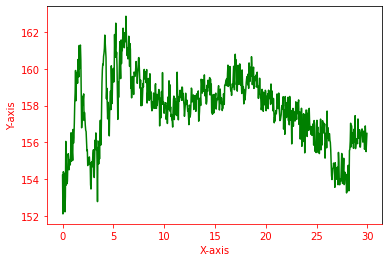

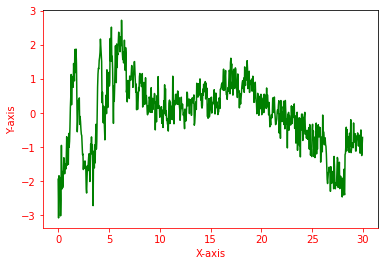

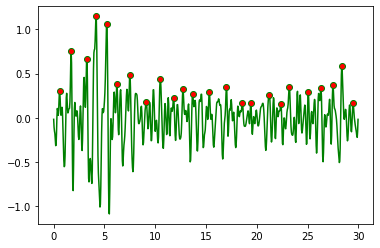

[ 0.6   1.72  3.28  4.16  5.24  6.24  7.52  9.12 10.48 11.8  12.72 13.68
 15.32 17.   18.56 19.4  21.24 22.36 23.2  25.08 26.32 27.48 28.36 29.48]


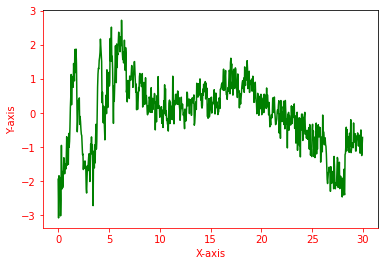

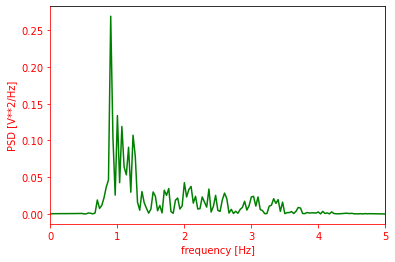

[2021-05-02 00:48:22,148] [INFO] [find_hr_in_window] [129] : Window 0:
Highest freq:0.9
Heart rate: 54.0


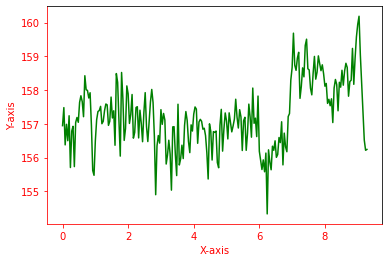

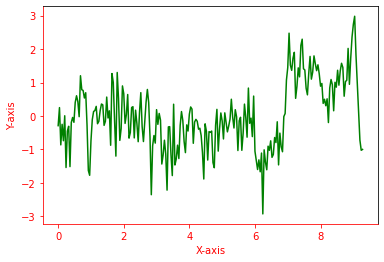

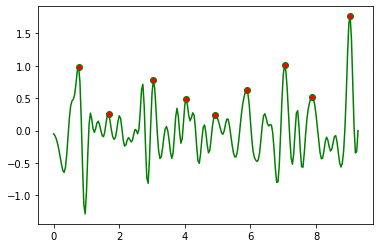

[0.76 1.68 3.04 4.04 4.92 5.88 7.04 7.88 9.04]


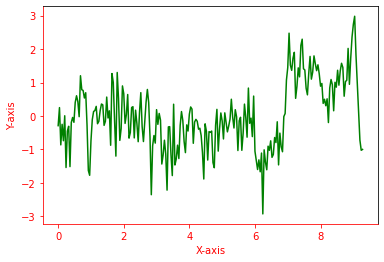

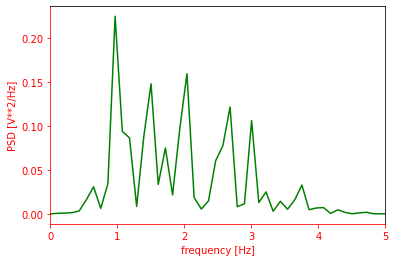

[2021-05-02 00:48:23,094] [INFO] [find_hr_in_window] [129] : Window 1:
Highest freq:0.9656652360515021
Heart rate: 57.93991416309013


In [89]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

window_start = 0
window_size = 30
window_id = 0
limit = good_frame_number - int(round_fps) * window_size
while window_start < limit :
    find_hr_in_window(green, window_start, round_fps, window_id, window_size)
    window_start += int(round_fps) * window_size
    window_id += 1
if window_start < good_frame_number:
    find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

In [78]:
# a = Pxx_den
# ind = np.argsort(a)
# max_ind = ind[-5:]
# print(f[max_ind])
# print("HR for this video is: " +str(f[max_ind].mean()))

In [79]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [80]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [81]:
# f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [85]:
# plt.figure(f, Pxx_den)
# #plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()
# # periodogram method:
# f, Pxx_den = sig.periodogram(green_buttered, round_fps)
# plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()
print(round_fps)

25.0
